# Машинное обучение в бизнесе
## Урок 4. Построение и оценка модели

In [10]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
)
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

In [14]:
def fit_model(data, h, column="PJME_MW", split_date="2017-01-01", print_metrics=True):
    data_exp = exponential_smoothing(data[column], 0.05)
    df = pd.DataFrame(data_exp, index=data.index)
    # добавили историю на глубину 3 измерения от текущего (р=3)
    df["t"] = 0
    df.iloc[1:, 1] = df.iloc[:-1, 0].values
    df["t1"] = 0
    df.iloc[2:, 2] = df.iloc[:-2, 0].values
    df["t2"] = 0
    df.iloc[3:, 3] = df.iloc[:-3, 0].values
    df.fillna(0)
    # добавили сглаживание (3 вида - просто для коллекции)
    df["exp_0_01"] = exponential_smoothing(df[0], 0.01)
    df["exp_0_03"] = exponential_smoothing(df[0], 0.03)
    df["exp_0_08"] = exponential_smoothing(df[0], 0.08)
    # добавим разности - 1-й порядок
    df["diff1"] = 0
    df["diff1"].iloc[1:] = df.iloc[1:, 0].values - df.iloc[:-1, 0].values
    # разобьем данные на train и test выборки
    train = df.loc[df.index <= split_date].copy()
    test = df.loc[df.index > split_date].copy()
    # добавим данные шага h в данные
    X_train = train.iloc[:-h, :]
    y_train = train[df.columns[0]].values[h:]
    X_test = test.iloc[:-h, :]
    y_test = test[df.columns[0]].values[h:]
    # обучим модель
    model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
    model_gb.fit(X_train, y_train)
    y_pred = model_gb.predict(X_test)
    # метрики модели
    if print_metrics:
        print(f"Для h={h}:")
        print("mean_absolute_error =", mean_absolute_error(y_test, y_pred))
        print("mean_squared_error =", mean_squared_error(y_test, y_pred))
        print("median_absolute_error =", median_absolute_error(y_test, y_pred))
        print("r2 =", r2_score(y_test, y_pred))
    mean_absolute_percentage_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return mean_absolute_percentage_error

### Задание 1

Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

***Решение***

In [2]:
data = pd.read_csv(
    "../lesson02/my_PJME_MW.csv", index_col=[0], parse_dates=[0]
).sort_index()
data.head(3)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0


In [3]:
data_w = (
    data[["PJME_MW", "year", "month", "quarter", "weekofyear"]]
    .resample("W")
    .mean()
    .sort_index()
)
data_w.head(3)

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2002-01-06,32392.160839,2002.0,1.0,1.0,1.0
2002-01-13,31487.386905,2002.0,1.0,1.0,2.0
2002-01-20,31452.880952,2002.0,1.0,1.0,3.0


### Задание 2

Постройте модель предсказания $4$ точки от текущей ($h = 4$), используя результаты автокорреляционного анализа из предшествующих уроков.

***Решение***

In [12]:
fit_model(data_w, h=4)

Для h=4:
mean_absolute_error = 646.681923040656
mean_squared_error = 624875.1475675061
median_absolute_error = 591.7135439290323
r2 = -0.33173862291625


2.0898507128795982

### Задание 3

Постройте модель предсказания $1$ точки от текущей ($h = 1$), используя результаты автокорреляционного анализа из предшествующих уроков.

***Решение***

In [13]:
fit_model(data_w, h=1)

Для h=1:
mean_absolute_error = 176.01360415740172
mean_squared_error = 50366.43531408598
median_absolute_error = 136.7051288638031
r2 = 0.8901950951934486


0.5694573430653127

### Задание 4

Примените авторекурсию и сравните результат в $4$ точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из $4$ точек.

***Решение***

не понял что такое рекурсивное моделирование

### Задание 5

Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от $1$ до $10$, от $10$ до $20$, от $20$ до $30$, ..., от $90$ до $100$ точках (используйте осреднение по десяткам точек).

***Решение***

In [26]:
mape = [(h, fit_model(data_w, h, print_metrics=False)) for h in range(1, 81)]

In [27]:
mape_df = pd.DataFrame(mape, columns=["h", "mape"])
mape_df.groupby(np.arange(len(mape_df.index)) // 10).mean()

,h,mape
0,5.5,2.168733
1,15.5,2.582116
2,25.5,3.534908
3,35.5,2.314931
4,45.5,1.922825
5,55.5,2.322174
6,65.5,2.970433
7,75.5,2.105908


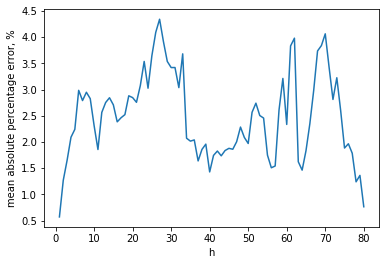

In [30]:
plt.plot(mape_df.h, mape_df.mape)
plt.xlabel("h")
plt.ylabel("mean absolute percentage error, %")
plt.show()

### Задание 6

Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

***Решение***

Похоже, что что-то пошло не так